### 1. What if we take ResNET model and directly run on the data without any fine tuning?
Lets see which class the model assigns the images to

#### Load data

In [9]:
import torch
from torch.utils import data

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data_folder = '/content/drive/MyDrive/CCAI 2024 Tutorials/1_LULC_ResNET50/data'

In [6]:
class EuroSAT(data.Dataset):
  def __init__(self,dataset,transform = None):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self,index):
    if self.transform:
      x = self.transform(dataset[index][0])
    else:
      x = dataset[index][0]
    y = dataset[index][1]
    return x,y

  def __len__(self):
    return len(dataset)

In [7]:
import os

In [8]:
train_loader = torch.load(os.path.join(data_folder,'train_loader.pth'))
val_loader = torch.load(os.path.join(data_folder,'val_loader.pth'))
test_loader = torch.load(os.path.join(data_folder,'test_loader.pth'))

<ipython-input-8-0b32d987e57a>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  train_loader = torch.load(os.path.join(data_folder,'train_loader.pth'))
<ipython-input-8-0b32

In [9]:
print(len(train_loader.dataset))
print(len(val_loader.dataset))
print(len(test_loader.dataset))

18900
4050
4050


In [39]:
import torch
from torchvision import models

In [40]:
model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 124MB/s]


In [12]:
NUM_CLASSES = 10

In [13]:
model.fc = torch.nn.Linear(in_features=model.fc.in_features,
                           out_features=NUM_CLASSES)

In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
print("Device = {}".format(device))

if str(device) == 'cuda:0':
  print('GPU {}'.format(torch.cuda.get_device_name(0)))

Device = cuda:0
GPU Tesla T4


In [15]:
model = model.to(device)

In [16]:
import torchsummary

In [17]:
torchsummary.summary(model,input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

### Let's check the model performance on test set

In [18]:
import tqdm

In [19]:
def evaluate(model,dataloader,criterion,phase='val'):
    model.eval()

    running_loss = 0.0
    running_total_correct = 0.0

    for i,(inputs,labels) in enumerate(tqdm.tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs,labels)
            _, preds = torch.max(outputs,1)

        running_loss += loss.item() * inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct / len(dataloader.dataset)) * 100
    print(f'{phase.title()} Loss = {epoch_loss:.2f}; Accuracy = {epoch_accuracy:.2f}')

    return epoch_loss,epoch_accuracy

In [20]:
criterion = torch.nn.CrossEntropyLoss()

In [21]:
from torchvision import datasets

In [22]:
dataset = datasets.ImageFolder(os.path.join(data_folder, 'EuroSAT','2750'))

In [3]:
test_loss, _ = evaluate(model, test_loader, criterion, phase="test")

NameError: name 'evaluate' is not defined

The test score looks quite poor.
Let's see what it is classifying the data as, for a few images

In [49]:
inputs, labels = next(iter(test_loader))

inputs = inputs.to(device)
labels = labels.to(device)

with torch.set_grad_enabled(False):
  outputs = model(inputs)
  loss = criterion(outputs, labels)
  _, preds = torch.max(outputs, 1)


In [34]:
labels

tensor([3, 4, 8, 7, 9, 9, 0, 1, 3, 7, 0, 5, 2, 1, 6, 4], device='cuda:0')

In [36]:
inputs[0].shape

torch.Size([3, 224, 224])

In [28]:
import matplotlib.pyplot as plt
import numpy as np

In [34]:
imagenet_mean, imagenet_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [30]:
class_names = dataset.classes

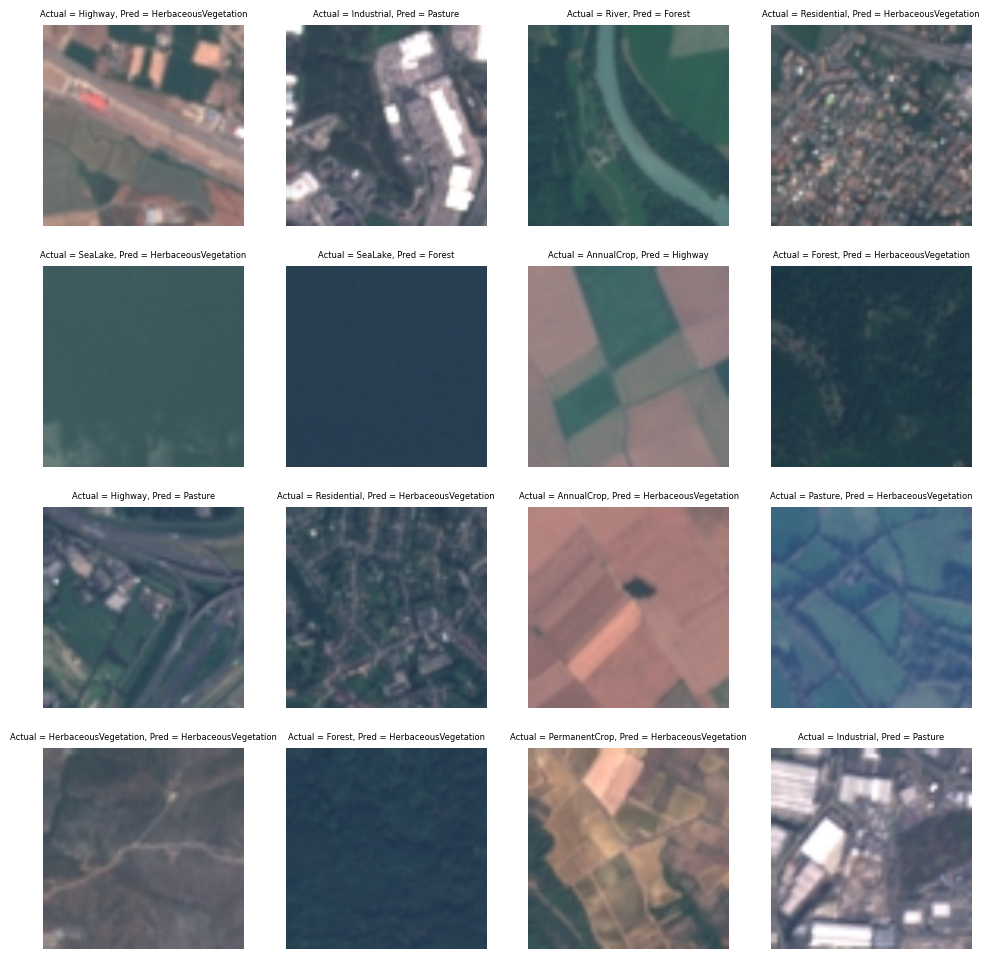

In [44]:
n = 4
fig, axes = plt.subplots(n, n, figsize=(12, 12))

for i in range(n):
  for j in range(n):
    # image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = inputs[i * n + j].cpu().numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = f"Actual = {class_names[labels[i * n + j]]}, Pred = {class_names[preds[i * n + j]]}"
    axes[i, j].imshow(image)
    axes[i, j].set_title(title,fontsize = 6)
    axes[i, j].axis('off')


Now lets train the model for 1 epoch and check the same.

In [45]:
def train(model,dataloader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    running_total_correct = 0.0

    for i,(inputs,labels) in enumerate(tqdm.tqdm(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # print(labels)

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = criterion(outputs,labels)

        loss.backward()

        optimizer.step()

        _,preds = torch.max(outputs,1)

        running_loss += loss.item() *inputs.size(0)
        running_total_correct += torch.sum(preds == labels)

    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_accuracy = (running_total_correct /  len(dataloader.dataset)) * 100
    print(f'Train loss : {epoch_loss:.2f};Accuracy : {epoch_accuracy:.2f}')

    return epoch_loss, epoch_accuracy

In [46]:
def fit(model,train_loader,val_loader,n_epochs,lr,criterion,optimizer):
    best_loss = np.inf
    best_model = None

    for epoch in range(n_epochs):
        print(f'Epoch : {epoch+1}')
        train(model,train_loader,criterion,optimizer)
        val_loss,_ = evaluate(model,val_loader,criterion)

        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model

    return best_model

In [47]:
n_epochs = 1
lr = 0.001
optimizer = torch.optim.SGD(model.parameters(),lr = lr)

In [48]:
best_model = fit(model,train_loader,val_loader,n_epochs,lr,criterion,optimizer)

Epoch : 1


100%|██████████| 1182/1182 [1:48:12<00:00,  5.49s/it]


Train loss : 1.75;Accuracy : 49.20


100%|██████████| 254/254 [22:58<00:00,  5.43s/it]

Val Loss = 1.30; Accuracy = 68.40


In [50]:
with torch.set_grad_enabled(False):
  outputs = best_model(inputs)
  loss = criterion(outputs, labels)
  _, preds = torch.max(outputs, 1)

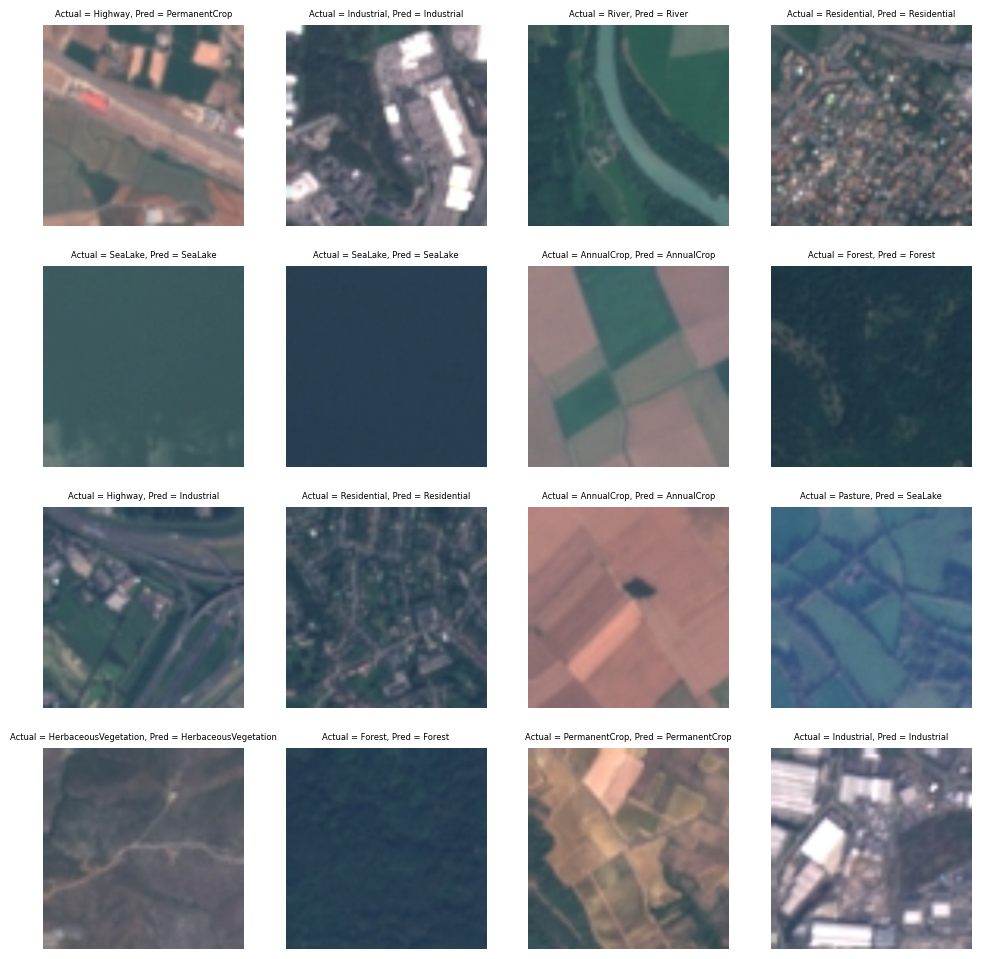

In [51]:
n = 4
fig, axes = plt.subplots(n, n, figsize=(12, 12))

for i in range(n):
  for j in range(n):
    # image = inputs[i * n + j].numpy().transpose((1, 2, 0))
    image = inputs[i * n + j].cpu().numpy().transpose((1, 2, 0))
    image = np.clip(np.array(imagenet_std) * image + np.array(imagenet_mean), 0, 1)

    title = f"Actual = {class_names[labels[i * n + j]]}, Pred = {class_names[preds[i * n + j]]}"
    axes[i, j].imshow(image)
    axes[i, j].set_title(title,fontsize = 6)
    axes[i, j].axis('off')


It got much better

### Imagenet model directly as an image classifier

In [5]:
# !pip install datasets

In [113]:
from transformers import AutoImageProcessor, ResNetForImageClassification
import os
from datasets import load_dataset
from PIL import Image


In [115]:
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

inputs = processor(image, return_tensors="pt")

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

hoopskirt, crinoline


### Run torch model

In [143]:
image_path = os.path.join(data_folder,'EuroSAT','2750','Highway','Highway_1.jpg')
image = Image.open(image_path)


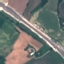

In [144]:
image

In [145]:
model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)
model.eval();

In [146]:
from torchvision import transforms
input_size = 224
test_transform = transforms.Compose([
    transforms.Resize(input_size),
    transforms.CenterCrop(input_size),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean,imagenet_std)
    ]
)

In [147]:
input = test_transform(image)

In [148]:
output = model(input.unsqueeze(0))
# output

In [149]:
probabilities = torch.nn.functional.softmax(output[0], dim=0)

In [150]:
probabilities

tensor([7.7460e-04, 5.1254e-04, 2.7128e-03, 1.2520e-03, 4.6440e-04, 1.3572e-03,
        8.4397e-04, 1.7750e-04, 1.9416e-04, 2.5096e-04, 7.5917e-04, 2.5464e-04,
        3.2222e-04, 2.5329e-04, 2.5445e-04, 3.9976e-04, 5.1432e-04, 2.6414e-04,
        2.2406e-04, 3.6892e-04, 2.6177e-04, 8.0433e-04, 2.6270e-04, 2.2427e-04,
        2.9127e-04, 2.3358e-04, 5.2786e-04, 2.5733e-04, 5.7854e-04, 6.4970e-04,
        4.6551e-04, 4.6885e-04, 6.8964e-04, 4.2335e-04, 6.2589e-04, 2.6313e-04,
        4.6589e-04, 2.3005e-04, 5.5441e-04, 5.0130e-04, 5.0030e-04, 1.3659e-03,
        4.7543e-04, 1.3190e-03, 3.5176e-04, 3.1901e-04, 2.4405e-04, 1.0854e-03,
        1.9147e-04, 2.8958e-04, 3.4251e-04, 4.3716e-04, 3.4015e-04, 4.7824e-04,
        4.8645e-04, 2.8203e-04, 2.2515e-04, 4.4269e-04, 4.3707e-04, 1.2692e-03,
        4.3186e-04, 3.7290e-04, 9.0081e-04, 1.0721e-03, 8.2838e-04, 3.8645e-04,
        9.0751e-04, 1.9605e-04, 5.6460e-04, 2.8507e-04, 3.8931e-04, 2.6326e-04,
        2.1658e-04, 8.9407e-04, 2.4568e-

In [151]:
# !wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

In [104]:
# with open("imagenet_classes.txt", "r") as f:
#     categories = [s.strip() for s in f.readlines()]


In [105]:
# categories

In [152]:
# Show top categories per image
top5_prob, top5_catid = torch.topk(probabilities, 5)

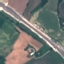

In [153]:
image

In [154]:
[categories[x] for x in top5_catid]

['revolver', 'space shuttle', 'oxygen mask', 'airliner', 'bassoon']